In [1]:
import pandas as pd

Так вышло, что названия колонок не те, которые ожидаются кодом)

In [19]:
table_names = ["baseline3.5.xlsx", "upgraded3.5.xlsx", "upgraded4-o.xlsx"]

for name in table_names:
    table = pd.read_excel(name).rename(columns={"agent_answer": "answers", "question": "questions", "gold_answer": "gold_answers"})
    print(table.head())
    table.to_excel(name, index=False)

                                       questions  \
0     Когда я последний раз покупала авиабилеты?   
1           Сколько стоил последний билет от ржд   
2      Сколько денег я потратила в Ural Airlines   
3  Какую сумму я потратила на ж/д билеты за 2024   
4                    Когда был последний перевод   

                                        gold_answers  \
0  Ваша последняя покупка авиабилетов была соверш...   
1               Последний билет стоил 1681,5 рублей.   
2  Всего за последний год вы потратили 18455 рублей.   
3      Суммарно вы потратили 32398 рублей на билеты.   
4  Последний перевод был совершен на сумму 243 RU...   

                                             answers  правдивость   \
0  Вы последний раз покупали авиабилеты 21 ноября...             5   
1          Последний билет от РЖД стоил 5000 рублей.             0   
2  Для определения суммы денег, которую вы потрат...             0   
3  В 2024 году вы потратили на ж/д билеты следующ...             0   


Вычислим метрики для всех таблиц

In [45]:
import pandas as pd
table_names = ["baseline3.5_metrics.csv", "upgraded3.5_metrics.csv", "upgraded4-o_metrics.csv"]

results = {}

for name in table_names:
    table = pd.read_csv(name)
    metrics = table.drop(["questions", "gold_answers", "answers", "rouge1", "rouge2", "rougeL"], axis=1).mean(axis=0)
    
    row_name = ".".join(name.split(".")[:-1])
    results[row_name] = metrics
    
metrics = pd.DataFrame(results)
metrics

,baseline3.5_metrics,upgraded3.5_metrics,upgraded4-o_metrics
bert_f1,0.726770,0.785140,0.752974
bert_precision,0.678648,0.750827,0.716721
bert_recall,0.785566,0.824206,0.795961
bleu,0.071466,0.100224,0.068657
judge_accuracy,1.538462,1.423077,3.307692
judge_calibration,1.846154,0.846154,2.461538
judge_recall,1.692308,1.769231,3.538462
judge_relevance,3.153846,2.692308,4.230769
judge_usefulness,2.384615,2.153846,3.653846
ner_f1,0.102404,0.075000,0.143681


Количество семплов мало, но все же посмотрим на корреляцию изобретенного нами ner_f1 и скора llm судьи

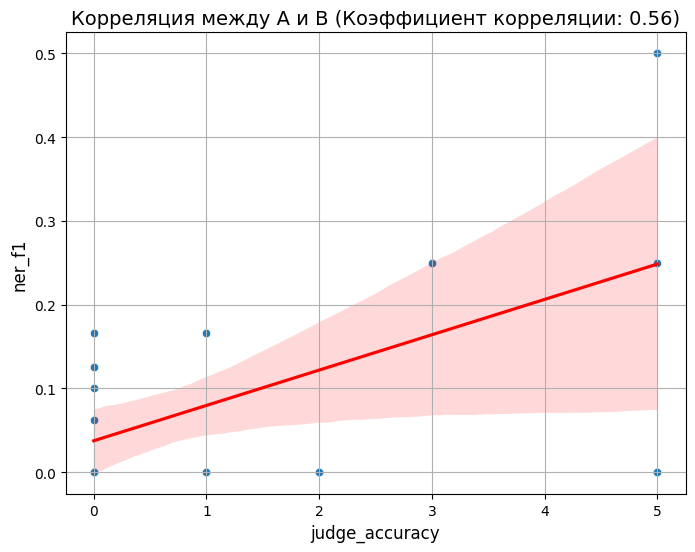

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

xlabel  = 'judge_accuracy'
ylabel = 'ner_f1'

for name in table_names:
    table = pd.read_csv(name)
    table = table.drop(["questions", "gold_answers", "answers", "rouge1", "rouge2", "rougeL"], axis=1)
    # Пример данных
    
    data = {
        ylabel: table[ylabel],
        xlabel: table[xlabel]
    }
    df = pd.DataFrame(data)
    
    # Расчет коэффициента корреляции
    correlation_coefficient = df[xlabel].corr(df[ylabel])
    
    # Построение графика
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=xlabel, y=ylabel, data=df)
    
    # Добавление линий регрессии
    sns.regplot(x=xlabel, y=ylabel, data=df, scatter=False, color='red')
    
    # Настройка заголовка и меток
    plt.title(f'Корреляция между A и B (Коэффициент корреляции: {correlation_coefficient:.2f})', fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    
    # Показать график
    plt.show()
    break


Построим таблички для презентации

In [82]:
splitted = []

bert_scores = metrics.loc[["bert_f1", "bert_precision", "bert_recall"] + ["bleu"]]
splitted.append(bert_scores)

judge_scores = metrics.loc[[name for name in metrics.index if name.startswith("judge")]]
splitted.append(judge_scores)


rouge1_scores =  metrics.loc[[name for name in metrics.index if name.startswith("rouge1")]]
splitted.append(rouge1_scores)

rouge2_scores =  metrics.loc[[name for name in metrics.index if name.startswith("rouge2")]]
splitted.append(rouge2_scores)


rougeL_scores =  metrics.loc[[name for name in metrics.index if name.startswith("rougeL")]]
splitted.append(rougeL_scores)


ner_scores = metrics.loc[[name for name in metrics.index if name.startswith("ner")]]
splitted.append(ner_scores)

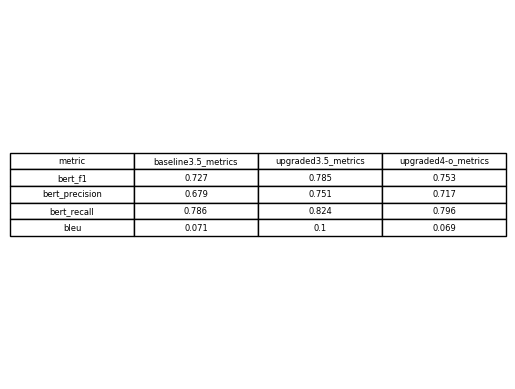

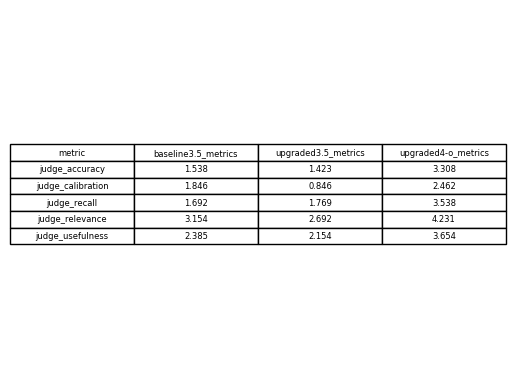

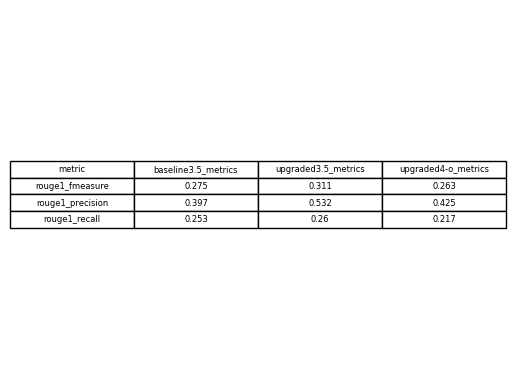

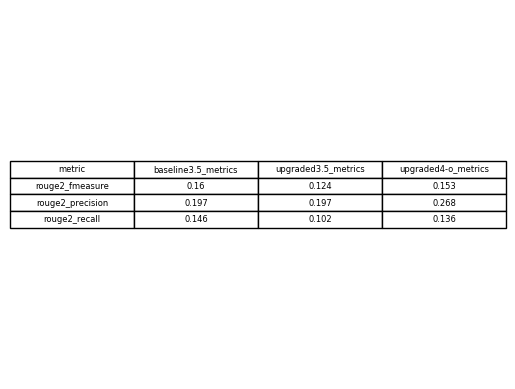

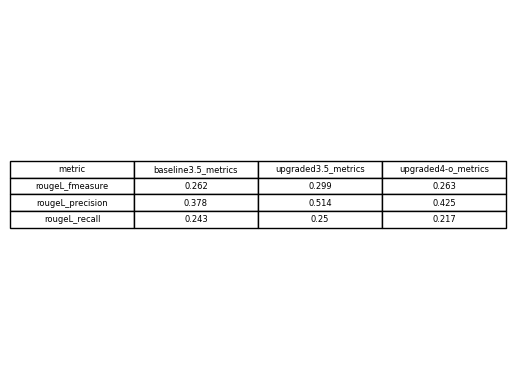

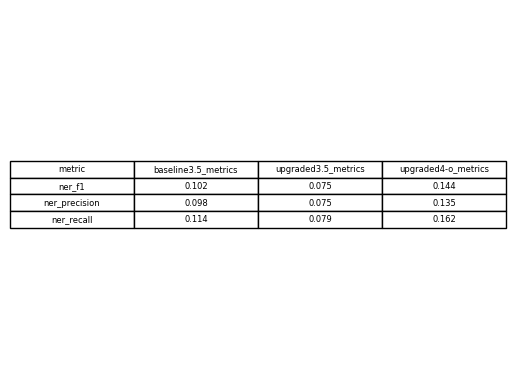

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Данные для таблицы
for scores in splitted:
    data = pd.DataFrame(scores).reset_index().rename(columns={"index": "metric"}).apply(lambda x: round(x, 3))
    
    # Визуализация
    fig, ax = plt.subplots()
    ax.set_facecolor('white')
    ax.axis('tight')
    ax.axis('off')
    
    colors = plt.cm.RdYlGn(np.linspace(0, 0.5, data.shape[1]))
    

    ax.table(cellText=data.values, colLabels=data.columns, cellLoc='center', loc='center')
    
    # Показать таблицу
    plt.show()